# UBC Medicine Datathon &mdash; Team 1

## 1. Import libraries

In [1]:
import os
import fnmatch
import shutil
import pickle

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
from torchinfo import summary
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    fbeta_score, ConfusionMatrixDisplay
)

ON_KAGGLE = os.getcwd() == '/kaggle/working'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Preparing the data set

### 2.1 Reading in summary CSV

In [2]:
if ON_KAGGLE:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
else:
    df = pd.read_csv('data/Data_Entry_2017.csv')

df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### 2.2 Transforming summary data set into tidy format

In [ ]:
# list all target types (all possible diseases under `Finding Labels`)
target_types = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
    'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia',
    'No Finding'
]

# renaming all target types to be syntactic
targets_tidy = {
    'Atelectasis': 'target_Atelectasis',
    'Cardiomegaly': 'target_Cardiomegaly',
    'Effusion': 'target_Effusion',
    'Infiltration': 'target_Infiltration', 
    'Mass': 'target_Mass',
    'Nodule': 'target_Nodule', 
    'Pneumonia': 'target_Pneumonia', 
    'Pneumothorax': 'target_Pneumothorax', 
    'Consolidation': 'target_Consolidation', 
    'Edema': 'target_Edema', 
    'Emphysema': 'target_Emphysema',
    'Fibrosis': 'target_Fibrosis',
    'Pleural_Thickening': 'target_Pleural_Thickening',
    'Hernia': 'target_Hernia',
    'No Finding': 'target_nil'
}

# extract non-empty columns
tidy_df = df.copy()
tidy_df = tidy_df.iloc[:, :7]

# rename all columns such that they are syntactic
tidy_df = tidy_df.rename(columns={
    'Image Index': 'xray_filepath',
    'Finding Labels': 'target',
    'Follow-up #': 'patient_followup',
    'Patient ID': 'patient_id',
    'Patient Age': 'patient_age',
    'Patient Gender': 'patient_gender',
    'View Position': 'xray_view'
})

# splitting up `Finding Labels` into their own individual labels
# similar to one-hot encoding
tidy_df['target'] = tidy_df['target'].apply(lambda x: x.split('|')).tolist()

for each in target_types:
    tidy_df[each] = False

for index, row in tidy_df.iterrows():
    for condition in row['target']:
        if condition in target_types:
            tidy_df.at[index, condition] = True

tidy_df = tidy_df.drop(columns=['target'])
tidy_df = tidy_df.rename(columns=targets_tidy)

tidy_df

,xray_filepath,patient_followup,patient_id,patient_age,patient_gender,xray_view,target_Atelectasis,target_Cardiomegaly,target_Effusion,target_Infiltration,...,target_Nodule,target_Pneumonia,target_Pneumothorax,target_Consolidation,target_Edema,target_Emphysema,target_Fibrosis,target_Pleural_Thickening,target_Hernia,target_nil
0,00000001_000.png,0,1,58,M,PA,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,00000001_001.png,1,1,58,M,PA,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,00000001_002.png,2,1,58,M,PA,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,00000002_000.png,0,2,81,M,PA,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,00000003_000.png,0,3,81,F,PA,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,1,30801,39,M,PA,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
112116,00030802_000.png,0,30802,29,M,PA,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
112117,00030803_000.png,0,30803,42,F,PA,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
112118,00030804_000.png,0,30804,30,F,PA,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### 2.3 Split data set into train-validation/test splits and positive/negative examples

In [ ]:
# get list of train-validation/test images
if ON_KAGGLE:
    TRAIN_VAL_LIST = '/kaggle/input/data/train_val_list.txt'
    TEST_LIST = '/kaggle/input/data/test_list.txt'
else:
    TRAIN_VAL_LIST = 'data/train_val_list.txt'

with open(TRAIN_VAL_LIST, 'r') as f:
    img_list = [line.rstrip() for line in f]

with open(TEST_LIST, 'r') as f:
    test_list = [line.rstrip() for line in f]

# split tidy dataframe into train-validation/test
img_df = tidy_df[tidy_df['xray_filepath'].isin(img_list)]
test_df = tidy_df[tidy_df['xray_filepath'].isin(test_list)]

# split train-validation dataframe into positive/negative examples
positive_df = img_df[img_df['target_Pneumothorax'] == True]
negative_df = img_df[img_df['target_Pneumothorax'] != True]

# downsample negative examples to address class imbalance
positive_count, _ = positive_df.shape
negative_resampled = negative_df.sample(positive_count, random_state=42)
test_resampled = test_df.sample(1000, random_state=42)
resampled_df = pd.concat([positive_df, negative_resampled])

# split df into train and validation splits
train_df, valid_df = train_test_split(
    resampled_df, test_size=0.2, random_state=42
)

# split train df based on targets
train_positive_df = train_df[train_df['target_Pneumothorax'] == True]
train_negative_df = train_df[train_df['target_Pneumothorax'] != True]

# split valid df based on targets
valid_positive_df = valid_df[valid_df['target_Pneumothorax'] == True]
valid_negative_df = valid_df[valid_df['target_Pneumothorax'] != True]

# split test df based on targets
test_positive_df = test_resampled[test_resampled['target_Pneumothorax'] == True]
test_negative_df = test_resampled[test_resampled['target_Pneumothorax'] != True]

# delete any existing directory where images can be stored in
# comment out if not needed
RESET_IMAGES_PATH = '/kaggle/working/images'
if os.path.exists(RESET_IMAGES_PATH):
   shutil.rmtree(RESET_IMAGES_PATH)

### 2.4 Sort images according to train/validation splits and positive/negative examples

In [ ]:
# delete any existing directory where images can be stored in
# comment out if not needed
RESET_IMAGES_PATH = '/kaggle/working/images'
if os.path.exists(RESET_IMAGES_PATH):
   shutil.rmtree(RESET_IMAGES_PATH)

In [ ]:
# since dataset of images is divided up into 12 different folders,
# we need to index all images to know in which folders they are in
def index_images(directories):
    """Produces a dictionary of image files and their relative paths.

    Parameters
    ----------
    directories : str
        Relative path where the images are stored in.

    Returns
    -------
    dict
        Dictionary that maps the image file to its relative path.
    """
    print('Indexing images...')
    image_dict = {}
    for dir_path in directories:
        for root, _, files in os.walk(dir_path):
            for filename in files:
                image_dict[filename] = os.path.join(root, filename)

    print('Done!')
    return image_dict

In [ ]:
# function that finds an image in the 12 folders
# function is not in use as this has large time complexity
def find_image(img_path, directories):
    """Finds an image that lies within a list of directories

    Parameters
    ----------
    img_path : str
        Name of the image.
    directories : list of str
        List of relative paths of all the directories to search in

    Returns
    -------
    None
    """
    for dir_path in directories:
        for root, _, files in os.walk(dir_path):
            for filename in fnmatch.filter(files, img_path):
                return os.path.join(root, filename)
    return None

In [ ]:
# specify filepaths
if ON_KAGGLE:
    ORIGINAL_DIR = [f'/kaggle/input/data/images_{i:03d}/images' for i in range(1, 13)]
    IMG_DIR = '/kaggle/working/images'

else:
    WORKING_DIR = 'data/images_001'
    IMG_DIR = 'data/images'

# to save time, load pickle file of indexed images and their locations
try:
    with open('/kaggle/working/image_dict.pkl', 'rb') as f:
        image_dict = pickle.load(f)
except:
    image_dict = index_images(ORIGINAL_DIR)
    with open('/kaggle/working/image_dict.pkl', 'wb') as f:
        pickle.dump(image_dict, f)

# specify folder paths
TRAIN_POS_PATH = os.path.join(IMG_DIR, 'train/pneumothorax')
TRAIN_NEG_PATH = os.path.join(IMG_DIR, 'train/not_pneumothorax')
VALID_POS_PATH = os.path.join(IMG_DIR, 'valid/pneumothorax')
VALID_NEG_PATH = os.path.join(IMG_DIR, 'valid/not_pneumothorax')
TEST_POS_PATH = os.path.join(IMG_DIR, 'test/pneumothorax')
TEST_NEG_PATH = os.path.join(IMG_DIR, 'test/not_pneumothorax')

# create new folders
folder_dict = {
    TRAIN_POS_PATH: TRAIN_POS_PATH,
    TRAIN_NEG_PATH: TRAIN_NEG_PATH,
    VALID_POS_PATH: VALID_POS_PATH,
    VALID_NEG_PATH: VALID_NEG_PATH,
    TEST_POS_PATH: TEST_POS_PATH,
    TEST_NEG_PATH: TEST_NEG_PATH
}

# move images to their respective folders
df_dict = {
    TRAIN_POS_PATH: train_positive_df,
    TRAIN_NEG_PATH: train_negative_df,
    VALID_POS_PATH: valid_positive_df,
    VALID_NEG_PATH: valid_negative_df,
    TEST_POS_PATH: test_positive_df,
    TEST_NEG_PATH: test_negative_df
}

if not os.path.exists(IMG_DIR):
    print('Moving images...')

    # create new folders
    for path in folder_dict.values():
        if not os.path.exists(path):
            os.makedirs(path)
    
    
    for NEW_PATH, df in df_dict.items():    
        for i in df['xray_filepath']:
            image_filename = os.path.basename(i)
            source = image_dict.get(image_filename)
            destination = os.path.join(NEW_PATH, image_filename)
    
            if source and os.path.exists(source):
                shutil.copy2(source, destination)

Indexing images...
Done!
Moving images...


### 2.5 Load images in

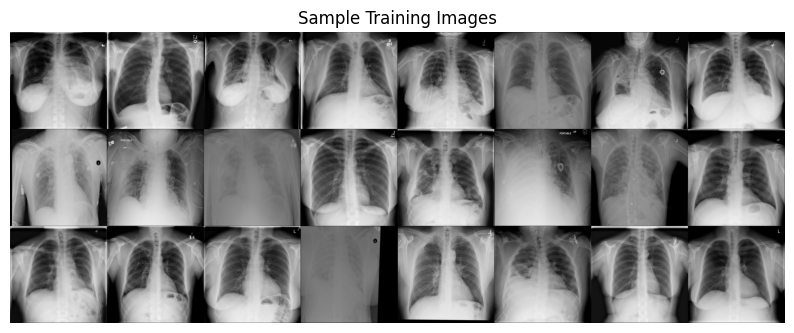

In [ ]:
if ON_KAGGLE:
    TRAIN_DIR = '/kaggle/working/images/train'
    VALID_DIR = '/kaggle/working/images/valid'
    TEST_DIR = '/kaggle/working/images/test'
else:
    TRAIN_DIR = "data/images/train/"
    VALID_DIR = "data/images/valid/"
    TEST_DIR = "data/images/test/"

IMAGE_SIZE = (512, 512)

# define transformation steps when loading in images
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard CIFAR-10 normalization
])

# load images to their respective datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=data_transforms)

BATCH_SIZE = 24

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

validloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

# check if images are successfully loaded
sample_batch = next(iter(trainloader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(
    np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0))
)

plt.show()

### 2.6 View labelled example

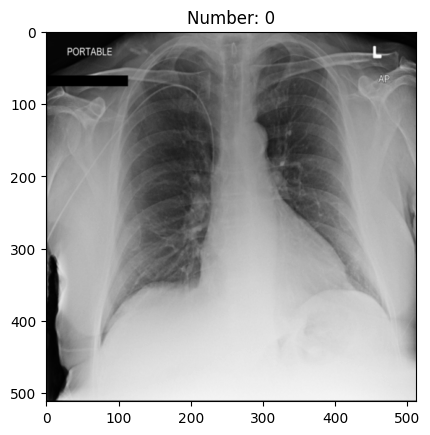

In [10]:
X, y = next(iter(trainloader))
plt.imshow(X[0, 0, :, :], cmap="gray")
plt.title(f"Number: {y[0].item()}");

## 3. Training the machine learning model

> Acknowledgement: These set of code has been adapted from teaching materials provided in DSCI 572 Supervised Learning II, a Master of Data Science course in the University of British Columbia.

### 3.1 Define the trainer function

In [ ]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Trainer function for the neural network.

    Parameters
    ----------
    model : torchvision.models
        A neural network built using PyTorch.
    criterion : torch.nn
        Loss function for model training.
    optimizer : torch.optim
        Optimisation algorithm to be used for model training.
    trainloader : torch.utils.data.DataLoader
        Dataset of training images that have been transformed and batched.
    validloader : torch.utils.data.DataLoader
        Dataset of validation images that have been transformed and batched.
    epochs : int, optional
        Number of full passes of `trainloader` for training, by default 5
    patience : int, optional
        Terminates training if training loss increases for specified
        number of batched, by default 5
    verbose : bool, optional
        Prints training status, by default True

    Returns
    -------
    dict
        Summary of training and validation results.
    """
    
    # initialise list to track loss and accuracy
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    consec_increases = 0
    
    for epoch in range(epochs):
        
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # training
        print('Start training...')
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_hat = model(X).flatten()                      # make output 1-dim
            y_hat_labels = torch.sigmoid(y_hat) > 0.5       # convert prob to True/False
            loss = criterion(y_hat, y.type(torch.float32))  # calculate loss
            loss.backward()                                 # obtain gradient values
            optimizer.step()

            train_batch_loss += loss.item()                 # sum loss for batch
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
            
        train_loss.append(train_batch_loss / len(trainloader))     # loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy per batch
        
        # validation
        print('Start validation...')

        # set to evaluation mode
        model.eval()
        
        # stop tracking gradients
        with torch.no_grad():

            for X, y in validloader:
                X, y = X.to(device), y.to(device)
                
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5        
                loss = criterion(y_hat, y.type(torch.float32))

                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
                
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))
        
        # set model back to train mode for next loop
        model.train()
        
        # print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
        
        # early stopping if loss increases for too many epochs
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1:3}: val loss increased for {consec_increases} consecutive epochs!")
            break
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    
    return results

### 3.2 Loading the pre-trained neural network

In [ ]:
# use default (pre-trained) weights as a starting point for training
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

# count number of output features
output_features = densenet.classifier.in_features

# modify classifier layers to suit our problem
new_layers = nn.Sequential(
    nn.Linear(output_features, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
)

densenet.classifier = new_layers

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.1MB/s]


In [ ]:
# enable parallelisation to speed up training
densenet = nn.DataParallel(densenet)

# use GPU to speed up training
densenet = densenet.to(device)

# sanity check to ensure that our model is connected correctly
summary(densenet, (BATCH_SIZE, 3, 512, 512))

Layer (type:depth-idx)                        Output Shape              Param #
DataParallel                                  [24, 1]                   --
├─DenseNet: 1-1                               [12, 1]                   7,517,477
├─DenseNet: 1-2                               [12, 1]                   --
├─DenseNet: 1-3                               --                        --
│    └─Sequential: 2-1                        [12, 1024, 16, 16]        --
│    └─Sequential: 2-4                        --                        (recursive)
│    │    └─Conv2d: 3-1                       [12, 64, 256, 256]        --
│    └─Sequential: 2-3                        [12, 1024, 16, 16]        6,953,856
│    └─Sequential: 2-4                        --                        (recursive)
│    │    └─Conv2d: 3-2                       [12, 64, 256, 256]        9,408
│    │    └─BatchNorm2d: 3-3                  [12, 64, 256, 256]        128
│    │    └─BatchNorm2d: 3-4                  [12, 64, 256,

### 3.3 Train the neural network

In [ ]:
# use binary cross-entropy loss since our problem is binary classification
criterion = nn.BCEWithLogitsLoss()

# use adam as the optimiser during training
optimizer = optim.Adam(densenet.parameters())

# train model and save results
results = trainer(densenet, criterion, optimizer, trainloader, validloader, epochs=5)

# save trained model weights
torch.save(densenet.state_dict(), "/kaggle/working/densenet.pt")

Start training...
Start validation...
Epoch   1: Train Loss: 0.689. Valid Loss: 0.692. Train Accuracy: 0.54. Valid Accuracy: 0.53.
Start training...
Start validation...
Epoch   2: Train Loss: 0.683. Valid Loss: 0.711. Train Accuracy: 0.56. Valid Accuracy: 0.55.
Start training...
Start validation...
Epoch   3: Train Loss: 0.680. Valid Loss: 0.694. Train Accuracy: 0.58. Valid Accuracy: 0.54.
Start training...
Start validation...
Epoch   4: Train Loss: 0.680. Valid Loss: 0.709. Train Accuracy: 0.57. Valid Accuracy: 0.54.
Start training...
Start validation...
Epoch   5: Train Loss: 0.679. Valid Loss: 0.689. Train Accuracy: 0.58. Valid Accuracy: 0.55.


## 4. Evaluating the trained model

> Acknowledgement: These set of code has been adapted from teaching materials provided in DSCI 572 Supervised Learning II, a Master of Data Science course in the University of British Columbia.

### 4.1 Create a batch evalation function

In [ ]:
def evaluate_batch(model, dataloader, device):
    """Evaluate neural network performance on a set of images.

    Parameters
    ----------
    model : torchvision.models
        A neural network built using PyTorch.
    dataloader : torch.utils.data.DataLoader
        Dataset of images to be evaluated.
    device : str
        The device where the evaluation is done (CPU or GPU).

    Returns
    -------
    dict
        Summary of evaluation results.
    """

    # set neural network to evaluation mode
    model.eval()
    
    true_label = list()
    pred_label = list()
    prob_1 = list()
        
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
                
            y_hat = model(X).flatten()
            y_hat_probs = torch.sigmoid(y_hat)
            y_hat_labels = y_hat_probs > 0.5  

            true_label.append(y.cpu().numpy())
            pred_label.append(y_hat_labels.cpu().numpy())
            prob_1.append(y_hat_probs.cpu().numpy())
        
    results = {
        "true_label": [int(item) for sublist in true_label for item in sublist],
        "pred_label": [int(item) for sublist in pred_label for item in sublist],
        "prob_1": [item for sublist in prob_1 for item in sublist]
    }
    
    return results

### 4.2 Evaluate model on training, validation and test batch

In [16]:
train_results = evaluate_batch(densenet, trainloader, device)
valid_results = evaluate_batch(densenet, validloader, device)
test_results = evaluate_batch(densenet, testloader, device)

### 4.3 Summary of evaluation results

In [17]:
train_summary = {
    "accuracy": accuracy_score(train_results['true_label'], train_results['pred_label']),
    "precision": precision_score(train_results['true_label'], train_results['pred_label']),
    "recall": recall_score(train_results['true_label'], train_results['pred_label']),
    "f2": fbeta_score(train_results['true_label'], train_results['pred_label'], beta=2)
}

valid_summary = {
    "accuracy": accuracy_score(valid_results['true_label'], valid_results['pred_label']),
    "precision": precision_score(valid_results['true_label'], valid_results['pred_label']),
    "recall": recall_score(valid_results['true_label'], valid_results['pred_label']),
    "f2": fbeta_score(valid_results['true_label'], valid_results['pred_label'], beta=2)
}

test_summary = {
    "accuracy": accuracy_score(test_results['true_label'], test_results['pred_label']),
    "precision": precision_score(test_results['true_label'], test_results['pred_label']),
    "recall": recall_score(test_results['true_label'], test_results['pred_label']),
    "f2": fbeta_score(test_results['true_label'], test_results['pred_label'], beta=2)
}

summary_df = dict()
summary_df['train'] = train_summary
summary_df['validation'] = valid_summary
summary_df['test'] = test_summary

pd.DataFrame(summary_df)

,train,validation,test
accuracy,0.579284,0.545972,0.434000
precision,0.580235,0.541667,0.130795
recall,0.582703,0.523992,0.658333
f2,0.582208,0.527434,0.364391


#### Confusion matrix for training batch

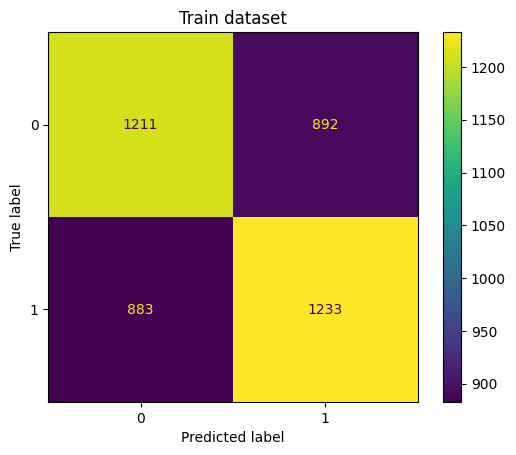

In [18]:
train_cm = ConfusionMatrixDisplay.from_predictions(
    train_results['true_label'], train_results['pred_label']
)

plt.title('Train dataset')
plt.show();

#### Confusion matrix for validation batch

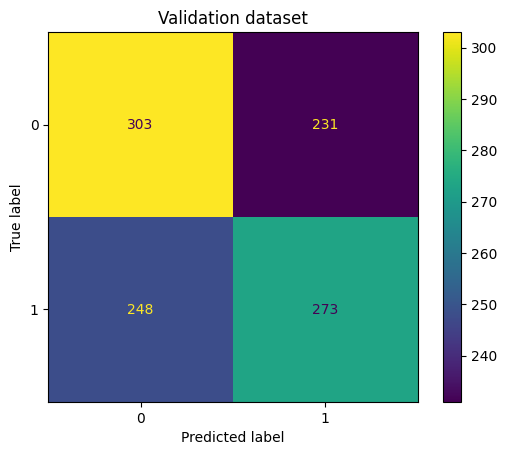

In [19]:
valid_cm = ConfusionMatrixDisplay.from_predictions(
    valid_results['true_label'], valid_results['pred_label']
)

plt.title('Validation dataset')
plt.show();

#### Confusion matrix for test batch

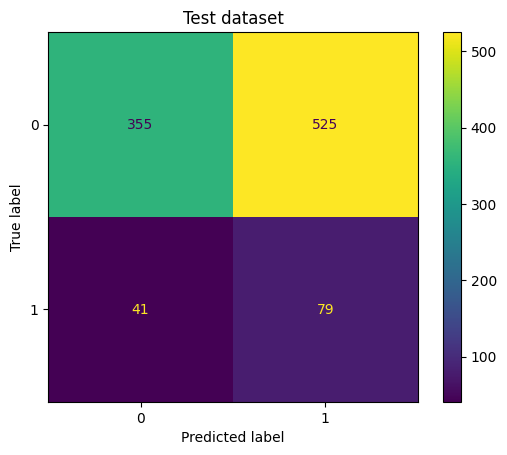

In [20]:
test_cm = ConfusionMatrixDisplay.from_predictions(
    test_results['true_label'], test_results['pred_label']
)

plt.title('Test dataset')
plt.show();

## 5. Model demostration

### 5.1 Define evaluation and label mapper functions

In [ ]:
def map_label(y):
    """Maps target output 0/1 to negative/positive for pneumothorax

    Parameters
    ----------
    y : int
        Target label for a given example.

    Returns
    -------
    str
        If pneumothorax is detected.
    """
    if isinstance(y, (list, torch.Tensor)):
        return ['Pneumothorax' if i != 0 else 'Negative' for i in y]
    else:
        return 'Pneumothorax' if y != 0 else 'Negative'

In [ ]:
def evaluate_xray(model, X, device):
    """Predicts probability of pneumothorax present given an x-ray image.

    Parameters
    ----------
    model : torchvision.models
        A neural network built using PyTorch that has been trained.
    X : numpy.ndarray
        X-ray image to be predicted on.
    device : str
        The device where the evaluation is done (CPU or GPU).

    Returns
    -------
    tuple
        Positive/negative label for pneumothorax with associated 
        probability of having pneumothorax.
    """
    model.eval()
        
    with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time

        X = X.to(device)
                
        y_hat = model(X).flatten()
        y_hat_probs = torch.sigmoid(y_hat)
        y_hat_labels = y_hat_probs > 0.5  
    
    return y_hat_labels.cpu().numpy(), y_hat_probs.cpu().numpy()

### 5.2 Demonstration of trained model

#### Loading the trained model

In [23]:
def load_trained_densenet121():
    model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
    
    output_features = model.classifier.in_features
    
    new_layers = nn.Sequential(
        nn.Linear(output_features, 500),
        nn.ReLU(),
        nn.Linear(500, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
    )
    
    model.classifier = new_layers
    
    model = nn.DataParallel(model)
    model = densenet.to(device)
    model.load_state_dict(torch.load('/kaggle/working/densenet.pt', weights_only=True))
    model.to(device)

    return model

#### Randomly choose image from test dataset and generate prediction

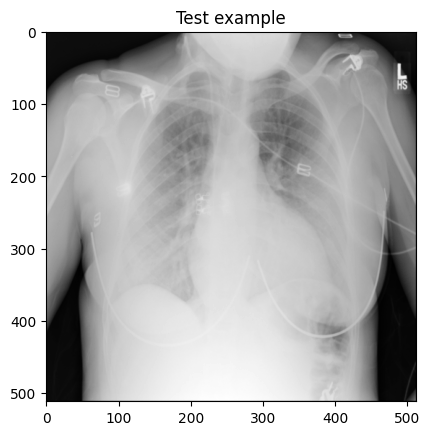

True :            Negative
Predicted :       Pneumothorax
P(pneumothorax) : 0.509


In [24]:
trained_model = load_trained_densenet121()

X, y = next(iter(testloader))

y_hat, y_prob = evaluate_xray(trained_model, X, device)

plt.imshow(X[0, 0, :, :], cmap="gray")
plt.title("Test example")
plt.show()

print(f'True :            {map_label(y[0].item())}')
print(f'Predicted :       {map_label(y_hat[0].item())}')
print(f'P(pneumothorax) : {y_prob[0].item():.03f}')